In [1]:
import numpy as np
from PIL import Image as im
from PIL import ImageOps as imo

# TO-DO
<ol>
    <li> Improve Markdown </li>
    <li> Add Function Descriptions </li>
    <li> Converts this to Cython or C </li>
    <li> Subsample 
        <ul>
            <li> Break Into N-Parts </li>
            <li> Determine Straight Line or Bezine Curve </li>
            <li> Create a list sequence of
                <ul>
                    <li> Straight </li>
                    <li> Concave </li>
                    <li> Convex </li>
                </ul>
            <li> Make Function to cycle through and determine similiarity </li>
        </ul>
    <li> Impliment Bkd trees to store all edges </li>
</ol>

In [2]:
def rot(old_coord):
    # Input: Last relative coordinate
    # Output: Next relative coordinate
    last = old_coord
    if   (last == (-1,-1)):
        return    (-1, 0)
    elif (last == (-1, 0)):
        return    (-1, 1)
    elif (last == (-1, 1)):
        return    (0, 1)
    elif (last == (0, 1)):
        return    (1, 1)
    elif (last == (1, 1)):
        return    (1, 0)
    elif (last == (1, 0)):
        return    (1, -1)
    elif (last == (1, -1)):
        return    (0, -1)
    else:
        return    (-1, -1)

In [3]:
def next_coord(coord, img, last_coord):
    # Input: x,y coordinate of current pixel
    #        numpy array of the image
    #        last pixel seen
    # Output: next pixel in clockwise order
    (y,x) = coord
    (last_y, last_x) = last_coord
    rel_coord = (last_y - y, last_x - x)
    for _ in range(7):
        (diff_y, diff_x) = rot(rel_coord)
        if (img[y + diff_y, x + diff_x] < 1):
            return (y + diff_y, x + diff_x)
        rel_coord = (diff_y, diff_x)
    return None

In [4]:
def outline(img, start):
    # Input: numpy array of the image (square, black white, pad white around)
    # Output of the pixels on the border of image
    # in clockwise order
    (height, weight) = img.shape
    last = (0,0)
    (offset_y, offset_x) = (-1, -1)
    (y,x) = start
    
    # Find the side that has white on it
    while(1):
        (offset_y, offset_x) = rot((offset_y, offset_x))
        if (img[y+offset_y, x+offset_x] == 1): #It is a white
            last = (y+offset_y, x+offset_x)
            break
        
    next_ = next_coord(start, img, last)
    last = start
    border = [start]
    while(True):
        if (next_ in border or next_ == None): # update to be next_ == start once bigger
            break
        else:
            border.append(next_)
            new_next = next_coord(next_, img, last)
            last = next_
            next_ = new_next
            
    return border

In [5]:
def is_edge(img, coord):
    (y,x) = coord
    (height, width) = img.shape
    if (x == 0 or x == width - 1):
        return False
    if (y == 0 or y == height - 1):
        return False
    
    neighbor = max(
        img[y-1,x-1], img[y-1,x], img[y-1, x+1],
        img[y+1,x-1], img[y+1,x], img[y+1, x+1],
        img[y,x+1],   img[y,x-1])
    
    return (neighbor == 1 and img[x,y] == 0)

In [6]:
def get_edges(data):
    edges = []
    for i, x in enumerate(data):
        for j, y in enumerate(x):
            if (is_edge(data, (i,j))):
                edges.append((i,j))
    return edges

In [7]:
def pad_data(data):
    (height, width) = data.shape
    data[:1,:] = 1
    data[(height-1):,:] = 1
    data[:,:1] = 1
    data[:, (width-1):] = 1
    return data

In [8]:
def plot_border(border, size):
    temp = np.zeros(shape=size)
    for (y,x) in border:
        temp[y,x] = 255

    temp = temp.astype(np.uint8)
    img = im.fromarray(temp)
    img = img.resize((80,80), resample=im.NEAREST)
    img.show()

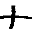

In [9]:
# SQUARE
square = np.zeros((32, 32), np.uint8)
square = square + 1.0
square[4:32-4, 4:32-4] = 0.0

# CIRCLE
xx, yy = np.mgrid[:32, :32]
dist = (xx - 16) ** 2 + (yy - 16) ** 2
circle = np.where(dist <= 64, 1, 0)
circle = (dist <= 64).astype(np.uint8)
circle = 1 - circle

# FIGURE
figure_img = im.open("imgs/fig23.png")
figure_img = imo.grayscale(figure_img)
figure_img = figure_img.resize((32,32), resample=im.NEAREST)
figure_img.show()
figure = np.asarray(figure_img) / 255
figure = figure.astype(np.uint8)

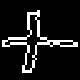

In [10]:
data = figure
data = pad_data(data)
edges = get_edges(data)
best = []
for edge in edges:
    temp = outline(data, edge)
    if (len(temp) > len(best)):
        best = temp
    if (len(best) > 0.3 * len(edges)):
        break
    
border = best #outline(data, edges[1])
plot_border(border, data.shape)

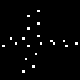

In [11]:
nparts = border[::len(border)//20]
plot_border(nparts, data.shape)

In [12]:
from scipy.special import comb

In [13]:
def bernstein_poly(i, n, t):
   """
     The Bernstein polynomial of n, i as a
     function of t
   """

   return comb(n, i) * (t ** (n - i)) * (1 - t) ** i

def bezier_curve(points, nTimes = 1000):
    """
    Given a set of control points,
    return the bezier curve defined by the control points.

    points should be a list of lists, or list of tuples
    such as [
       [1, 1],
       [2, 3],
       [4, 5], ..[Xn, Yn]
    ]
    nTimes is the number of time steps, defaults to 1000

    See http: //processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([bernstein_poly(i, nPoints - 1, t) for i in range(0, nPoints)])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

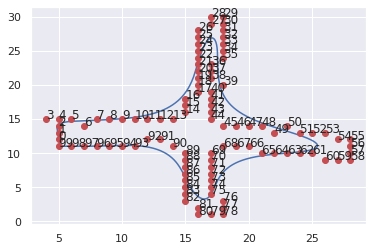

In [137]:
from matplotlib import pyplot as plt
points = border#[0:40]
nPoints = len(points)
xpoints = [p[0]
   for p in points
]
ypoints = [p[1]
   for p in points
]

xvals, yvals = bezier_curve(points, nTimes = 1000)
plt.plot(xvals, yvals)
plt.plot(xpoints, ypoints, "ro")
for nr in range(len(points)):
   plt.text(points[nr][0], points[nr][1], nr)

plt.show()

In [16]:
import seaborn
import bezier

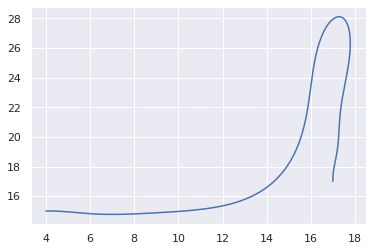

In [26]:
nodes = np.asfortranarray([xpoints, ypoints])
curve = bezier.Curve(nodes, degree=39)
seaborn.set()

ax = curve.plot(num_pts=256)

In [30]:
def dot(coord1, coord2):
    (x1, y1) = coord1
    (x2, y2) = coord2
    return (x1 * x2) + (y1 * y2)

The orthgonal projection of $\vec{v}$ onto $\vec{u}$

$$\text{proj}_{\vec{u}}(\vec{v}) = \frac{\vec{v}\cdot \vec{u}}{|\vec{u}|^2}\vec{u} = \frac{\vec{v}\cdot \vec{u}}{\vec{u} \cdot \vec{u}}\vec{u}$$

An example will be projecting the point $v = (2,3)$
onto the horizontal line described by $p \rightarrow q$ with $p = (1,1)$ and $q = (5,1).$

First normalize all the points with respect to $p$. $v' = (1,2), p' = (0,0), q' = (4,0).$ This creates the vector $\vec{v} = v'$ and $\vec{u} = q'$ 

$$\text{proj}_{\vec{u}}(\vec{v}) = \frac{4}{16} (4,0) = \frac{1}{4}(4,0) = (1,0)$$


In [41]:
p = (1,1)
q = (5,1)
v = (2,3)

# normalize v and q w.r.t p
vec_u = (q[0] - p[0], q[1] - p[1])
vec_v = (v[0] - p[0], v[1] - p[1])

scale = (dot(vec_v, vec_u) / dot(vec_u, vec_u))
proj = (scale*vec_u[0], scale*vec_u[1])
proj

(1.0, 0.0)

# Calculate Distance to Line

This gives a projection onto $\vec{u}$ but this doesn't tell us if it is above (concave) or below (convex). I really just care about distance to the line. Thus using the equation from [here](https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line) 

In [63]:
import math
def distance(P1, P2, p):
    (x0, y0) = p
    (x1, y1) = P1
    (x2, y2) = P2
    
    return abs((x2 - x1)*(y1 - y0) - (x1 - x0)*(y2 - y1)) / math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Determine the Side

Given three points $P_1,P_2,P_3$ the output of the $\textit{line side test}$ is "LEFT" if the point $P_3$ is on the left of the ray $P_1 \rightarrow P_2$, "RIGHT" if the point $P_3$ is on the right of ray $P_1 \rightarrow P_2$, and "ON" if it on that ray.

The algorithm is to construct the vectors $V_2 = P_2 - P_1$ and $V_3 = P_3 - P_1$. Then take the cross product of $V_2$ and $V_3$ and look at its value compared to 0.

$$V_2 \times V_3 = \text{Signed area of Parallelogram (negative by right hand rule)} $$

In the implementation <code> line_side_test </code>: <br>
1 is returned if $P_3$ is "LEFT" of the ray $P_1 \rightarrow P_2$, <br>
-1 if "RIGHT, <br>
0 if "ON"

In [61]:
def minus(P1, P2):
    return (P1[0] - P2[0], P1[1] - P2[1])

def cross(P1, P2):
    (x1, y1) = P1
    (x2, y2) = P2
    return (x1*y2) - (y1*x2)
    
def sign(x):
    if (x<0):
        return -1
    elif (x>0):
        return 1
    else:
        return 0
    
def line_side_test(P1, P2, P3):
    return sign(cross(minus(P2, P1), minus(P3, P1)))

In [64]:
p1 = (0, 0)
p2 = (0, 5)
p3 = (1,0)

print(line_side_test(p1, p2, p3), distance(p1, p2, p3))

-1 1.0


# Determine the Concavity of a Segment

Given a list of points going from $P_1$ to $P_{n}$ in order. Determine the concavity of the arc of points. 

In [132]:
from enum import Enum, unique
@unique
class Curvage(Enum):
    Concave  = -1
    Line = 0
    Convex  = 1

class Geometry:
    def __init__(self, val):
        if (-0.5 < val < 0.5):
            self.cur = Curvage(0)
        else:
            self.cur = Curvage(sign(val))
        
    def __sub__(self, other):
        val1 = self.cur.value
        val2 = other.cur.value
        return abs(val2 - val1)
    
    def __str__(self):
        return self.cur.name
    
def line_type(segment):
    p1 = segment[0]
    p2 = segment[-1]
    x = sum(map(lambda p3: line_side_test(p1, p2, p3)  * distance(p1, p2, p3), segment))
    val = x / len(segment) #average rise over run
    return Geometry(val)

# Determine the Direction of a Segment

Given $P_1$ and $P_2$, I want to figure out which cardinal direction (**N, E, S, W, NE, SE, SW, NW**) it is closest to. 
$$\text{angle (deg)} = \arctan(y,x) * 180/\pi$$

<code> math.atan2(y,x) </code> returns the arc tangent of y/x, in rad. <br>
The return value is between $(-\pi, \pi]$

In [117]:
from enum import Enum, unique
@unique
class Cardinal(Enum):
    N  = 0
    NE = 1
    E  = 2
    SE = 3
    S  = 4
    SW = 5
    W  = 6
    NW = 7

class Compass:
    def __init__(self, deg):
        temp = round(deg / 45, 0) % 8
        self.dir = Cardinal(temp)
        
    def __sub__(self, other):
        val1 = self.dir.value
        val2 = other.dir.value
        return min((val1 - val2) % 8, (val2 - val1) % 8)
    
    def __str__(self):
        return self.dir.name
    
def direction(P1, P2):
    (x,y) = minus(P2, P1)
    angle = math.atan2(x,y) * 180 / math.pi
    if angle < 0:
        angle = angle + 360 
    return Compass(angle)
    

In [109]:
p1 = (0,0)
p2 = (1.288,1.53)
print(direction(p1, p2))

NE


Given the border of points, I want to create a list of directions to recreate it. So I partition the border into 16 equal sized sections. Then for each segment we calculate the cardinal direction from the first to the last point. Then we also calculate the curvage of the point given the distance and side from the line.

In [136]:
border = np.roll(border, 5)
segments = np.array_split(border, 16)
for segment in segments:
    p1 = segment[0]
    p2 = segment[-1]
    print(line_type(segment), direction(p1, p2))

Convex NE
Line E
Line N
Line N
Line S
Concave S
Line S
Line E
Convex SE
Line W
Concave W
Line S
Convex SW
Line N
Concave NW
Line W
